In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_244',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=6.30957365501672e-05)

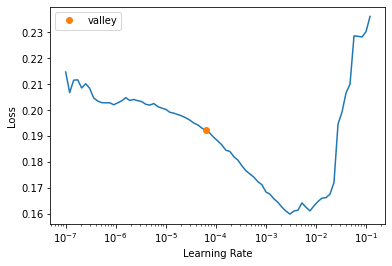

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.117874,9.102296,0.500000,0.500000,0.020513,0.039409,0.566450,01:18


Better model found at epoch 0 with f1_score value: 0.03940886699507389.


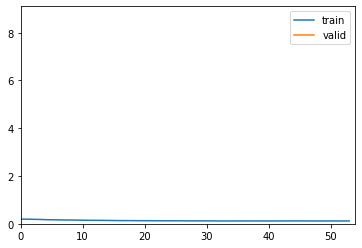

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.081956,0.067059,0.898718,0.930748,0.861538,0.894807,0.964119,01:18
1,0.074328,0.065063,0.898718,0.923706,0.869231,0.895641,0.965158,01:19
2,0.067333,0.061579,0.905128,0.920213,0.887179,0.903394,0.969231,01:19
3,0.064026,0.075299,0.882051,0.957055,0.800000,0.871508,0.964116,01:18
4,0.059294,0.065548,0.902564,0.919786,0.882051,0.900524,0.964744,01:18
5,0.053265,0.069826,0.896154,0.883375,0.912821,0.897856,0.963718,01:17
6,0.048733,0.069158,0.906410,0.916010,0.894872,0.905318,0.962163,01:18
7,0.048121,0.075482,0.894872,0.923077,0.861538,0.891247,0.956105,01:19


Better model found at epoch 0 with f1_score value: 0.8948069241011984.


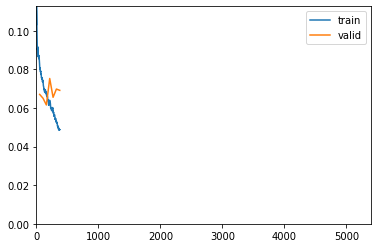

Better model found at epoch 1 with f1_score value: 0.8956406869220608.
Better model found at epoch 2 with f1_score value: 0.9033942558746736.
Better model found at epoch 6 with f1_score value: 0.9053177691309988.
No improvement since epoch 2: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9599326758711374.


(#6) [0.07220511138439178,0.8994871973991394,0.9087093389296957,0.8882051282051282,0.8983402489626557,0.9599326758711374]

# 384

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('inception_resnet_v2_244')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0002290867705596611)

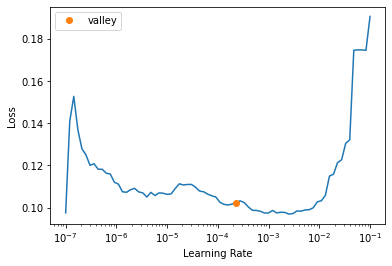

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.131165,0.119043,0.798718,0.830028,0.751282,0.788694,0.883291,02:24


Better model found at epoch 0 with f1_score value: 0.7886944818304171.


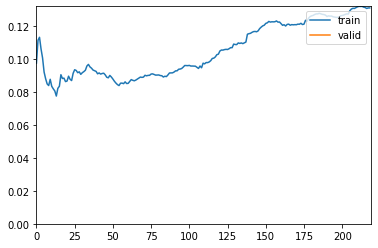

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.088308,0.078484,0.870513,0.947368,0.784615,0.858345,0.959425,02:24
1,0.082605,0.069737,0.901282,0.931129,0.866667,0.897742,0.961785,02:24
2,0.078802,0.070408,0.894872,0.913978,0.871795,0.892388,0.958600,02:24
3,0.078162,0.064134,0.900000,0.928571,0.866667,0.896552,0.968031,02:24
4,0.074275,0.064145,0.905128,0.924731,0.882051,0.902887,0.966446,02:23
5,0.076014,0.084375,0.878205,0.945619,0.802564,0.868239,0.960720,02:20
6,0.073907,0.073119,0.889744,0.934286,0.838462,0.883784,0.959615,02:20
7,0.070224,0.063227,0.894872,0.905263,0.882051,0.893506,0.966515,02:20
8,0.073893,0.068379,0.908974,0.946779,0.866667,0.904953,0.963481,02:21
9,0.072220,0.090662,0.876923,0.950920,0.794872,0.865922,0.962097,02:24


Better model found at epoch 0 with f1_score value: 0.8583450210378681.


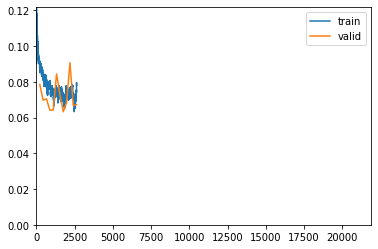

Better model found at epoch 1 with f1_score value: 0.8977423638778221.
Better model found at epoch 4 with f1_score value: 0.9028871391076115.
Better model found at epoch 8 with f1_score value: 0.9049531459170013.
Better model found at epoch 10 with f1_score value: 0.9058524173027989.
No improvement since epoch 7: early stopping


In [13]:
learn.fine_tune(100,base_lr=6e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9584015779092702.


(#6) [0.06927990168333054,0.8984615206718445,0.9017580144777663,0.8943589743589744,0.898043254376931,0.9584015779092702]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('inception_resnet_v2_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=2.0892961401841603e-05)

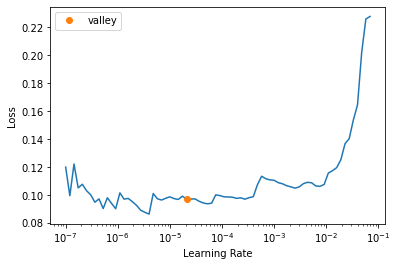

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.079477,0.066421,0.889744,0.934286,0.838462,0.883784,0.967837,05:33


Better model found at epoch 0 with f1_score value: 0.8837837837837837.


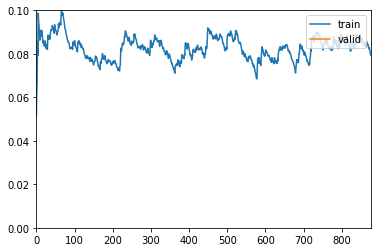

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.075230,0.063958,0.897436,0.942857,0.846154,0.891892,0.970638,05:34
1,0.067547,0.060434,0.907692,0.936813,0.874359,0.904509,0.970579,05:34
2,0.056518,0.061950,0.903846,0.943662,0.858974,0.899329,0.971410,05:34
3,0.061648,0.061023,0.910256,0.937158,0.879487,0.907407,0.971262,05:34
4,0.061044,0.057548,0.908974,0.914286,0.902564,0.908387,0.971995,05:34
5,0.049588,0.058276,0.907692,0.916230,0.897436,0.906736,0.971719,05:37
6,0.057870,0.060794,0.902564,0.943503,0.856410,0.897849,0.972482,05:35
7,0.060448,0.059829,0.903846,0.924528,0.879487,0.901445,0.970105,05:36
8,0.052149,0.062176,0.900000,0.926230,0.869231,0.896825,0.969915,05:35
9,0.055834,0.059500,0.908974,0.927614,0.887179,0.906946,0.971203,05:37


Better model found at epoch 0 with f1_score value: 0.8918918918918919.


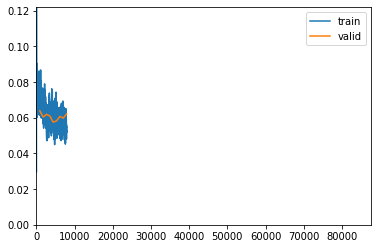

Better model found at epoch 1 with f1_score value: 0.9045092838196286.
Better model found at epoch 3 with f1_score value: 0.9074074074074074.
Better model found at epoch 4 with f1_score value: 0.9083870967741936.
No improvement since epoch 4: early stopping


In [12]:
learn.fine_tune(100,base_lr=6e-4)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9604823142669296.


(#6) [0.07013288140296936,0.9046154022216797,0.9105098855359001,0.8974358974358975,0.9039256198347106,0.9604823142669296]